In [1]:
from scipy import stats
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RESULT_DIR = '../../results/correlation-tests/'
PREFIX_DIR = os.path.join(RESULT_DIR, 'prefix-alignment', 'processed')

hmm_dirname = os.listdir(os.path.join(RESULT_DIR, 'hmmconf'))[0]
HMMCONF_DIR = os.path.join(RESULT_DIR, 'hmmconf')
PATT_DIR = os.path.join(RESULT_DIR, 'pattern')

In [3]:
def join_dfs(store, k=5, type_='test'):
    dfs = list()
    to_keep = [
        'case_prefix',
        'caseid',
        'completeness',
        'finalconf',
        'injected_distance',
    ]
    df_name = '{}_hmmconf_feature_fold_{}_df'
    for i in range(k):
        df_name_i = df_name.format(type_, i)
        # print('Adding {}'.format(df_name_i))
        df_i = store[df_name_i]
        df_i = df_i[to_keep]
        df_i['fold_no'] = i 
        dfs.append(df_i)
    df = pd.concat(dfs)
    df = df.reset_index(drop=True)
    del dfs
    return df
    
    
def process_hmmconf_df(df):
    # add log and caseid
    split = df['caseid'].str.split(':', n=1, expand=True)
    df['log'] = split[0].str.replace('.csv', '')
    df['caseid'] = split[1]
    df['case_length'] = df['case_prefix'].str.split(';').apply(lambda r: len(r))
    df['activity'] = df['case_prefix'].str.split(';').apply(lambda r: r[-1])
    to_keep = [
        'caseid',
        'completeness',
        'finalconf',
        'net',
        'log',
        'case_length',
        'injected_distance',
        'activity',
        'fold_no'
    ]
    return df[to_keep]

def process_hmmconf_result_dir(result_dir):
    test_df_list = list()
    
    for net in os.listdir(result_dir):
        print('Processing {}'.format(net))
        net_result_dir = os.path.join(result_dir, net)
        store_fp = os.path.join(net_result_dir, 'results_store.h5')
        store = pd.HDFStore(store_fp)
        
        test_df = join_dfs(store, k=5, type_='test')
        # train_df = join_dfs(store, k=5, type_='train')
        test_df['net'] = net
        # train_df['net'] = net
        test_df = process_hmmconf_df(test_df)
        test_df_list.append(test_df)
        # train_df_list.append(train_df)
        store.close()
    
    # train_df = pd.concat(train_df_list).reset_index(drop=True)
    test_df = pd.concat(test_df_list).reset_index(drop=True)
    # test_df = process_hmmconf_df(test_df)
    # train_df = process_hmmconf_df(train_df)
    print('Finished processing {}'.format(result_dir))
    return test_df

In [4]:
hmm_test_df = process_hmmconf_result_dir(HMMCONF_DIR)

Processing model_triangular_10_20_30_id_49
Processing model_triangular_10_20_30_id_50
Processing model_triangular_10_20_30_id_8
Processing model_triangular_10_20_30_id_26
Processing model_triangular_10_20_30_id_32
Processing model_triangular_10_20_30_id_12
Processing model_triangular_10_20_30_id_14
Processing model_triangular_10_20_30_id_43
Processing model_triangular_10_20_30_id_19
Processing model_triangular_10_20_30_id_39
Processing model_triangular_10_20_30_id_15
Processing model_triangular_10_20_30_id_27
Finished processing ../../results/correlation-tests/hmmconf


In [5]:
prefix_df_list = []

for fname in os.listdir(PREFIX_DIR):
    if not fname.endswith('.csv'):
        continue
    fp = os.path.join(PREFIX_DIR, fname)
    df = pd.read_csv(fp)
    prefix_df_list.append(df)
    
prefix_df = pd.concat(prefix_df_list)

patt_df_list = []

for fname in os.listdir(PATT_DIR):
    if not fname.endswith('.csv'):
        continue
    fp = os.path.join(PATT_DIR, fname)
    df = pd.read_csv(fp, sep='\t')
    df['log'] = fname.replace('.csv', '')
    patt_df_list.append(df)

patt_df = pd.concat(patt_df_list)
patt_df.rename(columns={
    'T:concept:name': 'caseid',
    'E:concept:name': 'activity'
}, inplace=True)

# create case_length
patt_df['tmp'] = 1
patt_df['case_length'] = patt_df[['caseid', 'log', 'tmp']].groupby(['log', 'caseid']).cumsum()
patt_df.drop(columns=['tmp'], inplace=True)
patt_df['net'] = patt_df['log'].apply(lambda l: l.split('.pnml')[0].replace('log_', ''))
prefix_df['caseid'] = prefix_df['caseid'].astype(str)
patt_df['caseid'] = patt_df['caseid'].astype(str)

### Merge all results together

In [6]:
patt_df.head()

,caseid,activity,id,conformance,completeness,confidence,log,case_length,net
0,0,g,1.0,0.0,0.0,0.000,log_model_triangular_10_20_30_id_14.pnml_noise...,1,model_triangular_10_20_30_id_14
1,0,h,2.0,1.0,1.0,0.500,log_model_triangular_10_20_30_id_14.pnml_noise...,2,model_triangular_10_20_30_id_14
2,0,e,3.0,1.0,1.0,0.625,log_model_triangular_10_20_30_id_14.pnml_noise...,3,model_triangular_10_20_30_id_14
3,0,i,4.0,1.0,1.0,0.750,log_model_triangular_10_20_30_id_14.pnml_noise...,4,model_triangular_10_20_30_id_14
4,0,k,5.0,1.0,1.0,0.875,log_model_triangular_10_20_30_id_14.pnml_noise...,5,model_triangular_10_20_30_id_14


In [7]:
prefix_df.head()

,caseid,case_length,log,net,Length of the alignment found,Log move cost of alignment,Model move cost of alignment,Synchronous move cost of alignment,Cost of the alignment
0,0,1,log_model_triangular_10_20_30_id_14.pnml_noise...,model_triangular_10_20_30_id_14,1,0,0,0,0
1,0,2,log_model_triangular_10_20_30_id_14.pnml_noise...,model_triangular_10_20_30_id_14,2,0,0,0,0
2,0,3,log_model_triangular_10_20_30_id_14.pnml_noise...,model_triangular_10_20_30_id_14,3,0,0,0,0
3,0,4,log_model_triangular_10_20_30_id_14.pnml_noise...,model_triangular_10_20_30_id_14,5,0,0,0,0
4,0,5,log_model_triangular_10_20_30_id_14.pnml_noise...,model_triangular_10_20_30_id_14,6,0,0,0,0


In [8]:
hmm_test_df.head()

,caseid,completeness,finalconf,net,log,case_length,injected_distance,activity,fold_no
0,8,1.0,1.0,model_triangular_10_20_30_id_49,log_model_triangular_10_20_30_id_49.pnml_noise...,1,0,a,0
1,8,1.0,1.0,model_triangular_10_20_30_id_49,log_model_triangular_10_20_30_id_49.pnml_noise...,2,0,k,0
2,8,1.0,1.0,model_triangular_10_20_30_id_49,log_model_triangular_10_20_30_id_49.pnml_noise...,3,0,e,0
3,8,1.0,1.0,model_triangular_10_20_30_id_49,log_model_triangular_10_20_30_id_49.pnml_noise...,4,0,p,0
4,8,1.0,1.0,model_triangular_10_20_30_id_49,log_model_triangular_10_20_30_id_49.pnml_noise...,5,0,t,0


In [9]:
prefix_df.shape

(2895560, 9)

In [10]:
hmm_test_df.shape

(2895560, 9)

In [11]:
patt_df.shape

(2895560, 9)

In [12]:
merged_df = pd.merge(prefix_df, patt_df, on=['log', 'caseid', 'case_length', 'net'])
merged_df['caseid'] = merged_df['caseid'].astype(str)
merged_df = pd.merge(merged_df, hmm_test_df, on=['log', 'caseid', 'case_length', 'net'], suffixes=('_prefix', '_hmmconf'))

assert (merged_df['activity_prefix'] == merged_df['activity_hmmconf']).all()

merged_df.rename(columns={'activity_prefix': 'activity'}, inplace=True)
merged_df.drop(columns=['activity_hmmconf'], inplace=True)

# add model attributes
# NET_DIR = '../../data/BPM2018/correlation-tests/models'
# desc_fp = os.path.join(NET_DIR, 'description.csv')
# desc_df = pd.read_csv(desc_fp)
# get_netid = lambda s: s.replace('model_triangular_10_20_30_id_', '').replace('.pnml', '')
# desc_df['net_id'] = desc_df['net'].apply(get_netid)

# add to merged_df
get_netid = lambda s: s.replace('log_model_triangular_10_20_30_id_', '').split('.pnml')[0]
merged_df['net_id'] = merged_df['log'].apply(get_netid)

# merged_df = pd.merge(desc_df, merged_df, on='net_id')
merged_df.rename(columns={
    'Cost of the alignment': 'cost'
}, inplace=True)

In [13]:
mean_finalconf = merged_df.groupby(['log', 'caseid']).agg({'finalconf': np.mean}).reset_index()
mean_finalconf.rename(columns={
    'finalconf': 'mean_finalconf'
}, inplace=True)
merged_df = merged_df.merge(mean_finalconf, on=['log', 'caseid'])

### Spearman correlation with non-conforming results

In [14]:
noisy = merged_df['cost'] > 0
case_length = merged_df['case_length'] > 0

filtered_df = merged_df.loc[noisy & case_length, :]
rho_conf = stats.spearmanr(filtered_df['cost'], filtered_df['finalconf'])
rho_mean_conf = stats.spearmanr(filtered_df['cost'], filtered_df['mean_finalconf'])
rho_injected_distance = stats.spearmanr(filtered_df['cost'], filtered_df['injected_distance'])
rho_completeness = stats.spearmanr(filtered_df['cost'], filtered_df['completeness_hmmconf'])

print(
    'Final conformance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf[0], rho_conf[1]),
    '\nMean conformance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_mean_conf[0], rho_mean_conf[1]), 
    '\nInjected distance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_injected_distance[0], rho_injected_distance[1]),
    '\nCompleteness: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_completeness[0], rho_completeness[1])
)

Final conformance: spearman rho: 0.459, p-value: 0.0000000000 
Mean conformance: spearman rho: 0.252, p-value: 0.0000000000 
Injected distance: spearman rho: 0.665, p-value: 0.0000000000 
Completeness: spearman rho: -0.519, p-value: 0.0000000000


/home/jwllee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


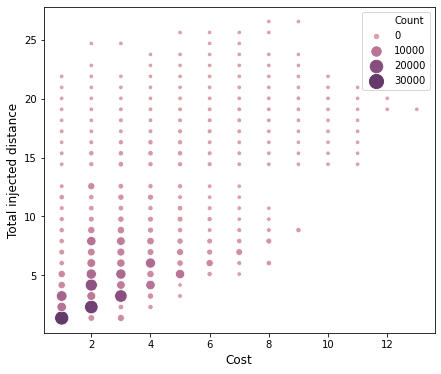

In [15]:
noisy = merged_df['cost'] > 0
case_length = merged_df['case_length'] >= 1
is_net = merged_df['net_id'] != '32'
scatter_df = merged_df.loc[noisy & case_length, :]

cost_var = 'cost'
var = 'injected_distance'
_min = scatter_df[var].min()
_max = scatter_df[var].max()
bins = np.linspace(_min, _max, 30)
scatter_df['binned'] = pd.cut(scatter_df[var], bins=bins)
grouped = scatter_df[[cost_var, 'binned', 'caseid']].groupby([cost_var, 'binned'])
bubble_df = grouped.count().reset_index(drop=False)
bubble_df[var] = bubble_df['binned'].apply(lambda interval: (interval.left + interval.right) / 2)
bubble_df.rename(columns={'caseid': 'Count'}, inplace=True)

fig, ax = plt.subplots(figsize=(7, 6))
cmap = sns.cubehelix_palette(dark=.3, light=.7, as_cmap=True)

g = sns.scatterplot(x=cost_var, y=var,
               hue='Count', size='Count',
               sizes=(20, 200), palette=cmap,
               data=bubble_df, ax=ax)

_ = ax.set_xlabel('Cost', size=12)
_ = ax.set_ylabel('Total injected distance', size=12)
# _ = ax.set_title('Bubble plot of noisy non-first event instances for {}'.format(var))

outdir = './images/svg/'
if not os.path.isdir(outdir):
    os.makedirs(outdir)

out_fp = os.path.join(outdir, 'cost-injection-unconform-bubble-epsilon.svg')
fig.savefig(out_fp, bbox_inches='tight', rasterized=True)

### Spearman correlation with conforming results

In [16]:
noisy = merged_df['cost'] > -1
case_length = merged_df['case_length'] > 0

filtered_df = merged_df.loc[noisy & case_length, :]
rho_conf = stats.spearmanr(filtered_df['cost'], filtered_df['finalconf'])
rho_mean_conf = stats.spearmanr(filtered_df['cost'], filtered_df['mean_finalconf'])
rho_injected_distance = stats.spearmanr(filtered_df['cost'], filtered_df['injected_distance'])
rho_completeness = stats.spearmanr(filtered_df['cost'], filtered_df['completeness_hmmconf'])

print(
    'Final conformance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf[0], rho_conf[1]),
    '\nMean conformance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_mean_conf[0], rho_mean_conf[1]), 
    '\nInjected distance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_injected_distance[0], rho_injected_distance[1]),
    '\nCompleteness: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_completeness[0], rho_completeness[1])
)

Final conformance: spearman rho: -0.408, p-value: 0.0000000000 
Mean conformance: spearman rho: -0.470, p-value: 0.0000000000 
Injected distance: spearman rho: 0.697, p-value: 0.0000000000 
Completeness: spearman rho: -0.712, p-value: 0.0000000000


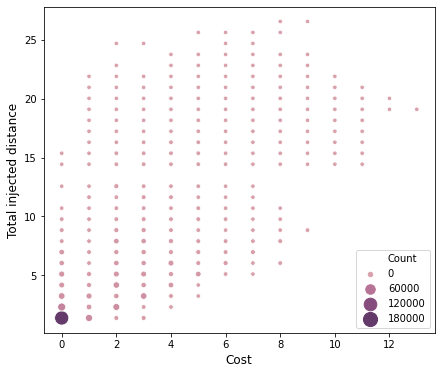

In [17]:
noisy = merged_df['cost'] > -1
case_length = merged_df['case_length'] >= 1
is_net = merged_df['net_id'] != '32'
scatter_df = merged_df.loc[noisy & case_length, :]

cost_var = 'cost'
var = 'injected_distance'
_min = scatter_df[var].min()
_max = scatter_df[var].max()
bins = np.linspace(_min, _max, 30)
scatter_df['binned'] = pd.cut(scatter_df[var], bins=bins)
grouped = scatter_df[[cost_var, 'binned', 'caseid']].groupby([cost_var, 'binned'])
bubble_df = grouped.count().reset_index(drop=False)
bubble_df[var] = bubble_df['binned'].apply(lambda interval: (interval.left + interval.right) / 2)
bubble_df.rename(columns={'caseid': 'Count'}, inplace=True)

fig, ax = plt.subplots(figsize=(7, 6))
cmap = sns.cubehelix_palette(dark=.3, light=.7, as_cmap=True)

sns.scatterplot(x=cost_var, y=var,
               hue='Count', size='Count',
               sizes=(20, 200), palette=cmap,
               data=bubble_df, ax=ax)

_ = ax.set_xlabel('Cost', size=12)
_ = ax.set_ylabel('Total injected distance', size=12)
# _ = ax.set_title('Bubble plot of noisy non-first event instances for {}'.format(var))

outdir = './images/svg/'
if not os.path.isdir(outdir):
    os.makedirs(outdir)

out_fp = os.path.join(outdir, 'cost-injection-all-bubble-epsilon.svg')
fig.savefig(out_fp, bbox_inches='tight', rasterized=True)

### Confusion matrix for fitting categorization

In [18]:
merged_df.head()

,caseid,case_length,log,net,Length of the alignment found,Log move cost of alignment,Model move cost of alignment,Synchronous move cost of alignment,cost,activity,id,conformance,completeness_prefix,confidence,completeness_hmmconf,finalconf,injected_distance,fold_no,net_id,mean_finalconf
0,0,1,log_model_triangular_10_20_30_id_14.pnml_noise...,model_triangular_10_20_30_id_14,1,0,0,0,0,g,1.0,0.0,0.0,0.000,1.0,1.0,0,1,14,1.0
1,0,2,log_model_triangular_10_20_30_id_14.pnml_noise...,model_triangular_10_20_30_id_14,2,0,0,0,0,h,2.0,1.0,1.0,0.500,1.0,1.0,0,1,14,1.0
2,0,3,log_model_triangular_10_20_30_id_14.pnml_noise...,model_triangular_10_20_30_id_14,3,0,0,0,0,e,3.0,1.0,1.0,0.625,1.0,1.0,0,1,14,1.0
3,0,4,log_model_triangular_10_20_30_id_14.pnml_noise...,model_triangular_10_20_30_id_14,5,0,0,0,0,i,4.0,1.0,1.0,0.750,1.0,1.0,0,1,14,1.0
4,0,5,log_model_triangular_10_20_30_id_14.pnml_noise...,model_triangular_10_20_30_id_14,6,0,0,0,0,k,5.0,1.0,1.0,0.875,1.0,1.0,0,1,14,1.0


In [24]:
y_true = merged_df['cost'] == 0
y_pred = (merged_df['finalconf'] > 0.99) & (merged_df['injected_distance'] == 0)

from sklearn.metrics import confusion_matrix

cnf_mat = confusion_matrix(y_true, y_pred)
precision = cnf_mat[1, 1] / cnf_mat[:, 1].sum()
recall = cnf_mat[1, 1] / cnf_mat[1, :].sum()
f1 = 2 * ((precision * recall) / (precision + recall))

print('Confusion matrix: \n{}\nPrecision: {:.5f}, Recall: {:.5f}, F1: {:.5f}'.format(cnf_mat, precision, recall, f1))
print('Total negatives: {}, Total positives: {}, Predicted negatives: {}, Predicted positives: {}'.format(cnf_mat[0, :].sum(), cnf_mat[1, :].sum(), 
                                                                                                       cnf_mat[:, 0].sum(), cnf_mat[:, 1].sum()))


Confusion matrix: 
[[ 450794   17763]
 [ 333356 2093647]]
Precision: 0.99159, Recall: 0.86265, F1: 0.92263
Total negatives: 468557, Total positives: 2427003, Predicted negatives: 784150, Predicted positives: 2111410


### Confusion matrix for pattern based

In [25]:
y_true = merged_df['cost'] == 0
y_pred = merged_df['conformance'] == 1

from sklearn.metrics import confusion_matrix

cnf_mat = confusion_matrix(y_true, y_pred)
precision = cnf_mat[1, 1] / cnf_mat[:, 1].sum()
recall = cnf_mat[1, 1] / cnf_mat[1, :].sum()
f1 = 2 * ((precision * recall) / (precision + recall))

print('Confusion matrix: \n{}\nPrecision: {:.5f}, Recall: {:.5f}, F1: {:.5f}'.format(cnf_mat, precision, recall, f1))
print('Total negatives: {}, Total positives: {}, Predicted negatives: {}, Predicted positives: {}'.format(cnf_mat[0, :].sum(), cnf_mat[1, :].sum(), 
                                                                                                       cnf_mat[:, 0].sum(), cnf_mat[:, 1].sum()))

Confusion matrix: 
[[  54021  414536]
 [ 232904 2194099]]
Precision: 0.84109, Recall: 0.90404, F1: 0.87143
Total negatives: 468557, Total positives: 2427003, Predicted negatives: 286925, Predicted positives: 2608635


### Dummy classifier as baseline

In [51]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

X = merged_df['log'].map(str) + '-' + merged_df['caseid']
y = merged_df['cost'] == 0

clf = DummyClassifier(strategy='stratified', random_state=123)

f1_scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
precision_scores = cross_val_score(clf, X, y, cv=5, scoring='precision')
recall_scores = cross_val_score(clf, X, y, cv=5, scoring='recall')

print('F1 score: {:.3f} +- {:.3f}'.format(np.mean(f1_scores), np.std(f1_scores)))
print('Precision: {:.3f} +- {:.3f}'.format(np.mean(precision_scores), np.std(precision_scores)))
print('Recall: {:.3f} +- {:.3f}'.format(np.mean(recall_scores), np.std(recall_scores)))

F1 score: 0.838 +- 0.000
Precision: 0.838 +- 0.000
Recall: 0.838 +- 0.000
